In [1]:
%run common.ipynb

['LC_Type1', 'LST_Day_1km', 'pr', 'aet', 'NDVI', 'EVI']
['LST_Day_1km', 'pr', 'aet', 'NDVI', 'EVI']
['LC_Type1']


In [2]:
%run tuning_common.ipynb

Using TensorFlow backend


In [3]:
MODEL_SAVE_DIR = f'{DOWNSTREAM_FINETUNE_DIR}model'

In [4]:
downstream_train_df = pd.read_csv(f'{DATA_FOLDER}{DOWNSTREAM_TRAIN_FILENAME}')
downstream_test_df = pd.read_csv(f'{DATA_FOLDER}{DOWNSTREAM_TEST_FILENAME}')
downstream_train_df = embed_catgorical_features(downstream_train_df, CATEGORICAL_FEATURES)
downstream_test_df = embed_catgorical_features(downstream_test_df, CATEGORICAL_FEATURES)

In [5]:
from sklearn.model_selection import train_test_split
split_train_df, split_val_df = train_test_split(downstream_train_df, test_size=0.2, shuffle=True, random_state=8)

In [6]:
split_train_tf = df_to_dataset(split_train_df[FEATURES + [TARGET_FEATURE]], TARGET_FEATURE, shuffle=True, batch_size=256)
split_val_tf = df_to_dataset(split_val_df[FEATURES + [TARGET_FEATURE]], TARGET_FEATURE, shuffle=False, batch_size=256)
downstream_test_input_tf = df_to_dataset(downstream_test_df[FEATURES], shuffle=False, batch_size=1)

/home/zheng.yant/ML-LUE/fttransformer/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
/home/zheng.yant/ML-LUE/fttransformer/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
/home/zheng.yant/ML-LUE/fttransformer/utils/preprocessing.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


In [29]:
class MyHyperModel(keras_tuner.HyperModel):
    def __init__(self, df_train):
        self.df_train = df_train
        
    def build(self, hp):
        d_embedding = hp.Int("d_embedding", min_value=32, max_value=512, step=8)
        n_layers = hp.Int("n_layers", min_value=1, max_value=4)
        ffn_factor = hp.Float("ffn_factor", min_value=2/3, max_value=8/3, sampling="linear")
        attention_dropout = hp.Float("attention_dropout", min_value=0.0, max_value=0.5, sampling="linear")
        ffn_dropout = hp.Float("ffn_dropout", min_value=0.0, max_value=0.5, sampling="linear")
        residual_dropout = hp.Float("residual_dropout", min_value=0.0, max_value=0.2, default=0.0, sampling="linear")

        lr = hp.Float("lr", min_value=1e-5, max_value=1e-3, sampling="log")
        weight_decay = hp.Float("weight_decay", min_value=1e-6, max_value=1e-3, sampling="log")
        
        mlp_head_unit_1 = hp.Int("mlp_head_unit_1", min_value=16, max_value=128, step=8)
        mlp_head_unit_2 = hp.Int("mlp_head_unit_2", min_value=16, max_value=128, step=8)
        
        model = compile_model(
            self.df_train,
            d_embedding=d_embedding, 
            n_layers=n_layers, 
            ffn_factor=ffn_factor,
            attention_dropout=attention_dropout,
            ffn_dropout=ffn_dropout,
            residual_dropout=residual_dropout,
            weight_decay=weight_decay,
            lr=lr,
            mlp_head_unit_1=mlp_head_unit_1,
            mlp_head_unit_2=mlp_head_unit_2
        )
        return model
    
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(*args, **kwargs)

In [12]:
hp = keras_tuner.HyperParameters()

In [13]:
import json
import os.path


class CustomCallback(tf.keras.callbacks.Callback):
    cur_trial_num = 0
    static_cur_best_result = np.Inf
    def __init__(
        self,
        filepath,
        log_dump_filepath,
        total_trial_sofar=0,
        monitor: str = "val_loss",
        mode: str = "auto",
        **kwargs,
    ):
        self.checkpoint = tf.keras.callbacks.ModelCheckpoint(
                                monitor=monitor,
                                mode=mode,
                                save_best_only=True,
                                filepath=filepath)
        self.log_dump_filepath = log_dump_filepath
        CustomCallback.cur_trial_num = total_trial_sofar
        if os.path.exists(self.log_dump_filepath):
            with open(self.log_dump_filepath) as f: 
                data = f.read() 
                # reconstructing the data as a dictionary 
                di = json.loads(data) 
                CustomCallback.static_cur_best_result = di['best_result']
                print(f'read best result {CustomCallback.static_cur_best_result} from {self.log_dump_filepath}')
        
        

    def set_params(self, params):
        self.checkpoint.set_params(params)

    def set_model(self, model):
        self.checkpoint.set_model(model)
    
    def on_train_begin(self, logs=None):
        CustomCallback.cur_trial_num += 1
        self.checkpoint.on_train_begin(logs)
        # keys = list(logs.keys())
        # print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        # print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        self.checkpoint.on_epoch_begin(epoch, logs)
        # keys = list(logs.keys())
        # print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.checkpoint.monitor) 
        if self.checkpoint.monitor_op(current, CustomCallback.static_cur_best_result):
            print('+++++ Get a better result, save the model +++++')
            self.checkpoint.on_epoch_end(epoch, logs)
            CustomCallback.static_cur_best_result = current
            # Data to be written
            dictionary = {
                "best_trial": CustomCallback.cur_trial_num,
                "best_result": current,
            }

            # Serializing json
            json_object = json.dumps(dictionary, indent=4)
            with open(self.log_dump_filepath, "w") as outfile:
                json.dump(dictionary, outfile)
        else:
            print('+++++ Not as good as the best so far, no saving +++++')
            self.checkpoint.epochs_since_last_save += 1

            
        # keys = list(logs.keys())
        # print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_train_batch_end(self, batch, logs=None):
        self.checkpoint.on_train_batch_end(batch, logs)
        # keys = list(logs.keys())
        # print("...Training: end of batch {}; got log keys: {}".format(batch, keys))


In [18]:
import json

def get_trial_sofar(filepath):
    if os.path.exists(filepath):
        f = open(filepath)
        data = json.load(f)
        return len(data['tried_so_far'])
        
    return 0

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor=finetune_objective[0].name, mode=finetune_objective[0].direction, patience=50, restore_best_weights=True),
    CustomCallback(
        monitor=finetune_objective[0].name,
        mode=finetune_objective[0].direction,
        filepath=MODEL_SAVE_DIR,
        log_dump_filepath=f'{DOWNSTREAM_FINETUNE_DIR}log_best_result.txt',
        total_trial_sofar=get_trial_sofar(f'{DOWNSTREAM_FINETUNE_DIR}finetune_progress/oracle.json')
    )
]

In [26]:
def start_fine_tune(objective, epochs=10, max_trials=20, overwrite=False):
    tf.keras.backend.clear_session()
    m = MyHyperModel(split_train_df)    
    tuner = get_random_search_instance(objective, DOWNSTREAM_FINETUNE_DIR, overwrite, m, max_trials=max_trials)
    tuner.search(split_train_tf, validation_data=split_val_tf, epochs=epochs, callbacks=callbacks)
    return tuner

## Fine tune with RMSE

### Fine tune

In [ ]:
tuner = start_fine_tune(finetune_objective, epochs=500, max_trials=50)

Trial 11 Complete [00h 14m 35s]
multi_objective: 6627.671875

Best multi_objective So Far: 4184.64794921875
Total elapsed time: 01h 49m 44s

Search: Running Trial #12

Value             |Best Value So Far |Hyperparameter
312               |104               |d_embedding
2                 |3                 |n_layers
1.4465            |1.3301            |ffn_factor
0.43667           |0.32296           |attention_dropout
0.30334           |0.42165           |ffn_dropout
0.16001           |0.083149          |residual_dropout
5.1834e-06        |0.00020817        |lr
5.8834e-06        |1.7098e-06        |weight_decay
32                |104               |mlp_head_unit_1
48                |112               |mlp_head_unit_2

Epoch 1/500
4/4 [==============================] - 8s 820ms/step - loss: 290690784.0000 - importances_loss: 145342016.0000 - output_loss: 145348768.0000 - importances_root_mean_squared_error: 12055.7881 - output_root_mean_squared_error: 12056.0674 - val_loss: 297186400.0

### Load best results and predict

In [9]:
model_reload=tf.keras.models.load_model(MODEL_SAVE_DIR)

 18/156 [==>...........................] - ETA: 1s

/home/zheng.yant/ML-LUE/fttransformer/utils/preprocessing.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


156/156 [==============================] - 4s 29ms/step
RMSE prediction: 4378.6497
RMSE MOD17: 4570.4151
R-Squared prediction: 0.5394358734508093
R-Squared MOD17: 0.49821116766445184
Max error prediction: 19443.530859375
Max error MOD17: 15912.398000000001
Mean poisson deviance prediction: 1495.8549066208757
Mean poisson deviance MOD17: 1808.7597388508084
Mean gamma deviance prediction: 0.16730688945944108
Mean gamma deviance MOD17: 0.23927812997292436
Mean pinball loss with alpha = 0.9 prediction: 1556.625392154948
Mean pinball loss with alpha = 0.9 MOD17: 2451.9100118689903
Mean pinball loss with alpha = 0.09999999999999998 prediction: 1662.6014546048677
Mean pinball loss with alpha = 0.09999999999999998 MOD17: 966.9264601862978


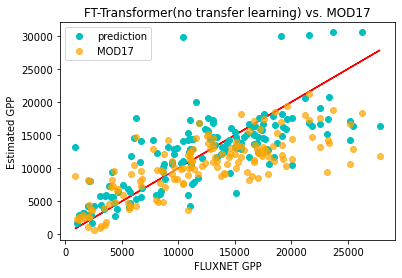

In [11]:
test_df = df_to_dataset(downstream_test_df[FEATURES], shuffle=False, batch_size=1)
predict_results = model_reload.predict(test_df)
y_pred = predict_results['output'].ravel()
modis_compare_data = get_modis_compare_data(y_pred)
get_all_metrics(y_pred, modis_compare_data[TARGET_FEATURE], downstream_test_df[TARGET_FEATURE])
plot_result_distribution(downstream_test_df[TARGET_FEATURE], y_pred, modis_compare_data[TARGET_FEATURE], save_dir=f'{MODEL_RESULT_PLT_DIR}FT-Transformer_no_upstream.png', title='FT-Transformer(no transfer learning) vs. MOD17')